In [1]:
import pandas
import datetime
import numpy
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [2]:
datFileName = "../data/processedSaps.txt"
sapsDataDF = pandas.read_csv(datFileName, sep=' ')
# add dst_bins
dstBins = [ -150, -75, -50, -25, -10, 10 ]
sapsDataDF = pandas.concat( [ sapsDataDF, \
                    pandas.cut( sapsDataDF["dst_index"], \
                               bins=dstBins ) ], axis=1 )
sapsDataDF.columns = [ "dateStr", "sapsLat", "sapsMLT", \
                      "sapsVel", "radId", "poesLat", "poesMLT", \
                      "dst_date", "dst_index", "time", "dst_bin" ]
sapsDataDF = sapsDataDF.drop(["radId", "poesLat", "poesMLT", "dst_date"], 1)
sapsDataDF.head()

,dateStr,sapsLat,sapsMLT,sapsVel,dst_index,time,dst_bin
0,20110107,56.5,17.7543,308.2077,-18.0,0,"(-25, -10]"
1,20110107,55.5,18.0147,224.1588,-18.0,0,"(-25, -10]"
2,20110107,56.5,17.8749,307.4328,-18.0,0,"(-25, -10]"
3,20110107,55.5,18.1324,222.4787,-18.0,0,"(-25, -10]"
4,20110107,56.5,17.9955,305.4201,-18.0,0,"(-25, -10]"


In [3]:
# Calculate the mean dst in each dst bin
dstBinMeans = sapsDataDF.groupby(["dst_bin"]).mean()
dstBinMeans = dstBinMeans.drop(["dateStr", "sapsLat", "sapsMLT", \
                                "sapsVel", "time"], 1)
dstBinMeans["dst_bin"] = dstBinMeans.index
dstBinMeans.reset_index(drop=True, inplace=True)
dstBinMeans.head()

,dst_index,dst_bin
0,-95.778902,"(-150, -75]"
1,-58.196502,"(-75, -50]"
2,-36.276175,"(-50, -25]"
3,-17.500758,"(-25, -10]"
4,-2.725928,"(-10, 10]"


In [4]:
# calculate prob of occ by dst_bin, MLT, Lat
sapsDataDF["sapsMLTRounded"] = sapsDataDF["sapsMLT"].map(lambda x: round(x) )
# get a normalized form of MLT where 
# if MLT > 12: MLT = MLT - 24, else MLT = MLT
sapsDataDF['normMLT'] = [x-24 if x >= 12 else x for x in sapsDataDF['sapsMLTRounded']]
sapsDataDF['normLAT'] = [x-57.5 for x in sapsDataDF['sapsLat']]
# Get max points at a given Lat, MLT, DstBin
dstGrps = sapsDataDF.groupby(["dst_bin", "sapsMLTRounded", "sapsLat", "normMLT", "normLAT"])
dstSapsMLTLatCountDF = pandas.DataFrame( dstGrps["sapsVel"].count() ).reset_index()
maxCntMLTLatDst = dstSapsMLTLatCountDF.groupby(["dst_bin"]).max().reset_index()
maxCntMLTLatDst = maxCntMLTLatDst.drop(["sapsMLTRounded", "sapsLat", "normMLT", "normLAT"], 1)
maxCntMLTLatDst.columns = ["dst_bin", "maxCount"]
dstSapsMLTLatCountDF = pandas.merge( dstSapsMLTLatCountDF, maxCntMLTLatDst, \
                              on=["dst_bin"], how='inner')
dstSapsMLTLatCountDF.columns = ["dst_bin", "sapsMLT", "sapsLat", "normMLT", "normLAT", "dataCount", "maxCount"]
dstSapsMLTLatCountDF["MLT"] = dstSapsMLTLatCountDF["sapsMLT"].map(lambda x: str(int(x)) )
dstSapsMLTLatCountDF["probOcc"] = dstSapsMLTLatCountDF["dataCount"]/dstSapsMLTLatCountDF["maxCount"]
dstSapsMLTLatCountDF.head()

,dst_bin,sapsMLT,sapsLat,normMLT,normLAT,dataCount,maxCount,MLT,probOcc
0,"(-150, -75]",0.0,51.5,0.0,-6.0,1,333,0,0.003003
1,"(-150, -75]",0.0,52.5,0.0,-5.0,22,333,0,0.066066
2,"(-150, -75]",0.0,53.5,0.0,-4.0,26,333,0,0.078078
3,"(-150, -75]",0.0,54.5,0.0,-3.0,36,333,0,0.108108
4,"(-150, -75]",0.0,55.5,0.0,-2.0,50,333,0,0.150150


In [5]:
# select the required dst_bin
# the bins are :
# ['(-150, -75]' '(-75, -50]' '(-50, -25]' '(-25, -10]' '(-10, 10]']
saps5075 = dstSapsMLTLatCountDF[ \
                    dstSapsMLTLatCountDF["dst_bin"] == "(-10, 10]" ]

In [6]:
sapsModelDF = pandas.DataFrame(columns=["normMLT", "normLAT", "probSAPS", "MLT", "Lat"])
latArr = []
mltArr = []
for x in range( int(saps5075["normLAT"].min()), int(saps5075["normLAT"].max()) + 1 ):
    for y in range( int(saps5075["normMLT"].min()), int(saps5075["normMLT"].max()) + 1 ):
        latArr.append(x)
        mltArr.append(y)
sapsModelDF["normMLT"] = mltArr
sapsModelDF["normLAT"] = latArr
sapsModelDF = pandas.merge( sapsModelDF, saps5075, on=["normMLT", "normLAT"], how="outer" )
sapsModelDF["probOcc"] = sapsModelDF["probOcc"].fillna(0.02)
# sapsModelDF = sapsModelDF[ ["normMLT", "normLAT", "probOcc"] ]
sapsModelDF.head()

,normMLT,normLAT,probSAPS,MLT_x,Lat,dst_bin,sapsMLT,sapsLat,dataCount,maxCount,MLT_y,probOcc
0,-9,-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02
1,-8,-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02
2,-7,-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02
3,-6,-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02
4,-5,-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02


In [7]:
def twoD_Gaussian((x, y), amplitude, xo, yo, sigma_x, sigma_y):
    theta = 0.633
    xo = float(xo)
    yo = float(yo)    
    a = (numpy.cos(theta)**2)/(2*sigma_x**2) + (numpy.sin(theta)**2)/(2*sigma_y**2)
    b = -1*(numpy.sin(2*theta))/(4*sigma_x**2) + (numpy.sin(2*theta))/(4*sigma_y**2)
    c = (numpy.sin(theta)**2)/(2*sigma_x**2) + (numpy.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*numpy.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

In [8]:
initGuess = (1,4,-1,2,2)
popt2, pcov2 = curve_fit(twoD_Gaussian, (sapsModelDF['normLAT'],sapsModelDF['normMLT']), sapsModelDF['probOcc'],
                       p0=initGuess)
print popt2 
print pcov2

[ 0.83570584  4.5310208  -1.25487903  3.27245002  1.6968925 ]
[[  4.49940931e-04  -2.49617309e-04   1.27913351e-04  -1.17799172e-03
   -4.66872699e-04]
 [ -2.49617309e-04   8.05479602e-03  -3.92479200e-03   4.20034225e-03
    1.99506946e-04]
 [  1.27913351e-04  -3.92479200e-03   4.40847338e-03  -2.45360375e-03
    5.32491554e-05]
 [ -1.17799172e-03   4.20034225e-03  -2.45360375e-03   1.23986331e-02
    4.42010537e-05]
 [ -4.66872699e-04   1.99506946e-04   5.32491554e-05   4.42010537e-05
    1.95331308e-03]]


In [9]:
dstBinArr = [ "(-150, -75]", "(-75, -50]", "(-50, -25]", "(-25, -10]", "(-10, 10]" ]
dstVals = [ -115., -65., -38., -18., 0. ]
ampArr = [ 1.00, 0.988, 1.02, 0.88, 0.84 ]
xoArr = [ -1.17, 0.56, 2.19, 3.65, 4.53 ]
yoArr = [ -3.94, -3.47, -2.69, -1.64, -1.25 ]
sigxArr = [ 2.78, 2.87, 2.82, 2.79, 3.27 ]
sigyArr = [ -1.75, 1.57, 1.79, 1.58, 1.69 ]
# Put this data in a DF
modelParamDF = pandas.DataFrame(columns=["dst_bin", "mean_dst", "amp", "xo", "yo", "sigx", "sigy"])
# Populate the DF
modelParamDF["dst_bin"] = dstBinArr
modelParamDF["mean_dst"] = dstVals
modelParamDF["amp"] = ampArr
modelParamDF["xo"] = xoArr
modelParamDF["yo"] = yoArr
modelParamDF["sigx"] = sigxArr
modelParamDF["sigy"] = sigyArr

# Merge the dstbin means with the DF to get mean vals
modelParamDF = pandas.merge( modelParamDF, dstBinMeans, on=["dst_bin"], how="inner" )

modelParamDF.head()

,dst_bin,mean_dst,amp,xo,yo,sigx,sigy,dst_index
0,"(-150, -75]",-115.0,1.000,-1.17,-3.94,2.78,-1.75,-95.778902
1,"(-75, -50]",-65.0,0.988,0.56,-3.47,2.87,1.57,-58.196502
2,"(-50, -25]",-38.0,1.020,2.19,-2.69,2.82,1.79,-36.276175
3,"(-25, -10]",-18.0,0.880,3.65,-1.64,2.79,1.58,-17.500758
4,"(-10, 10]",0.0,0.840,4.53,-1.25,3.27,1.69,-2.725928


In [10]:
# plot 
# modelParamDF.plot( x='mean_dst', y='sigy' )
# fit with np.polyfit
# m*x+b
m_amp, b_amp = numpy.polyfit(modelParamDF["dst_index"], modelParamDF["amp"], 1)
m_xo, b_xo = numpy.polyfit(modelParamDF["dst_index"], modelParamDF["xo"], 1)
m_yo, b_yo = numpy.polyfit(modelParamDF["dst_index"], modelParamDF["yo"], 1)
m_sx, b_sx = numpy.polyfit(modelParamDF["dst_index"], modelParamDF["sigx"], 1)
m_sy, b_sy = numpy.polyfit(modelParamDF["dst_index"], modelParamDF["sigy"], 1)
# MODEL PARAMS
print "################### SAPS MODEL ###################"
print "################### SAPS MODEL ###################"
print "theta = 0.633 rad"
print "A = " , round(b_amp,3) , "+ " , round(m_amp,3) , " * dst"
print "xo = " , round(b_xo,3) , "+ " , round(m_xo,3) , " * dst"
print "yo = " , round(b_yo,3) , "+ " , round(m_yo,3) , " * dst"
print "sigX = " , round(b_sx,3) , "+ " , round(m_sx,3) , " * dst"
print "sigY = " , round(b_sy,3) , "+ " , round(m_sy,3) , " * dst"
print "################### SAPS MODEL ###################"
print "################### SAPS MODEL ###################"

################### SAPS MODEL ###################
################### SAPS MODEL ###################
theta = 0.633 rad
A =  0.875 +  -0.002  * dst
xo =  4.595 +  0.063  * dst
yo =  -1.317 +  0.03  * dst
sigX =  3.051 +  0.003  * dst
sigY =  2.433 +  0.035  * dst
################### SAPS MODEL ###################
################### SAPS MODEL ###################


In [11]:
# model's function using the fitting params
def saps_model(mLatInp, mltInp, dstInp):
    x = mLatInp - 57.5
    if mltInp > 12:
        y = mltInp - 24
    else:
        y = mltInp
    # parameters from fitting
    (a_sx, b_sx, a_sy, b_sy, a_xo, b_xo, a_yo, b_yo, a_o, b_o, theta) = \
        ( 3.051, 0.003, 2.433, 0.035, 4.595,  \
           0.063, -1.317, 0.03, 0.875, -0.002, 0.63 )
    sigma_x = a_sx + b_sx * dstInp
    sigma_y = a_sy + b_sy * dstInp
    xo = a_xo + b_xo * dstInp
    yo = a_yo + b_yo * dstInp
    amplitude = a_o + b_o * dstInp
    
    a = (numpy.cos(theta)**2)/(2*sigma_x**2) + (numpy.sin(theta)**2)/(2*sigma_y**2)
    b = -(numpy.sin(2*theta))/(4*sigma_x**2) + (numpy.sin(2*theta))/(4*sigma_y**2)
    c = (numpy.sin(theta)**2)/(2*sigma_x**2) + (numpy.cos(theta)**2)/(2*sigma_y**2)
    outProb = amplitude*numpy.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return outProb

In [12]:
# dstSapsMLTLatCountDF = pandas.merge( dstSapsMLTLatCountDF, dstBinMeans, on=["dst_bin"], how="inner" )
# write the data to a file
outFileName = "../data/sapsProbs.txt"
dstSapsMLTLatCountDF.to_csv(outFileName, sep=' ', index=False)

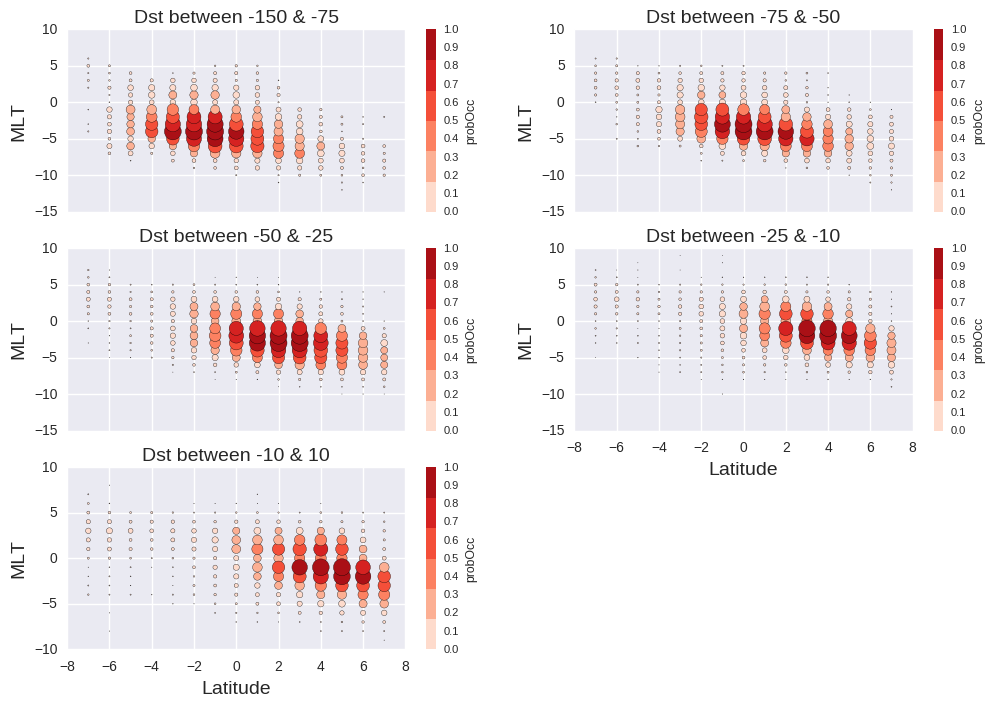

In [13]:
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax5 = f.add_subplot(3,2,5)
# plt.tick_params(axis='both', which='major', labelsize=16)
# f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# (-150,-75]
dstSapsMLTLat15075 = dstSapsMLTLatCountDF[ dstSapsMLTLatCountDF["dst_bin"] == "(-150, -75]" ]
dstSapsMLTLat15075.plot( kind='scatter',
              x='normLAT',
              y='normMLT',
              c='probOcc',
              s=dstSapsMLTLat15075["probOcc"]*150, cmap=seaMap, vmin=0, vmax=1, ax=ax1, sharex=True)
ax1.set_ylabel("MLT", fontsize=14)
# ax1.set_xlabel("Latitude", fontsize=14)
ax1.set_title( "Dst between -150 & -75", fontsize=14 )
# (-75, -50]
dstSapsMLTLat7550 = dstSapsMLTLatCountDF[ dstSapsMLTLatCountDF["dst_bin"] == "(-75, -50]" ]
dstSapsMLTLat7550.plot( kind='scatter',
              x='normLAT',
              y='normMLT',
              c='probOcc',
              s=dstSapsMLTLat7550["probOcc"]*150, cmap=seaMap, vmin=0, vmax=1, ax=ax2)
ax2.set_ylabel("MLT", fontsize=14)
ax2.set_xlabel("Latitude", fontsize=14)
ax2.set_title( "Dst between -75 & -50", fontsize=14 )
# (-50, -25]
dstSapsMLTLat5025 = dstSapsMLTLatCountDF[ dstSapsMLTLatCountDF["dst_bin"] == "(-50, -25]" ]
dstSapsMLTLat5025.plot( kind='scatter',
              x='normLAT',
              y='normMLT',
              c='probOcc',
              s=dstSapsMLTLat5025["probOcc"]*150, cmap=seaMap, vmin=0, vmax=1, ax=ax3)
ax3.set_ylabel("MLT", fontsize=14)
ax3.set_xlabel("Latitude", fontsize=14)
ax3.set_title( "Dst between -50 & -25", fontsize=14 )
# (-25, -10]
dstSapsMLTLat2510 = dstSapsMLTLatCountDF[ dstSapsMLTLatCountDF["dst_bin"] == "(-25, -10]" ]
dstSapsMLTLat2510.plot( kind='scatter',
              x='normLAT',
              y='normMLT',
              c='probOcc',
              s=dstSapsMLTLat2510["probOcc"]*150, cmap=seaMap, vmin=0, vmax=1, ax=ax4)
ax4.set_ylabel("MLT", fontsize=14)
ax4.set_xlabel("Latitude", fontsize=14)
ax4.set_title( "Dst between -25 & -10", fontsize=14 )
# (-10, 10]
dstSapsMLTLat1010 = dstSapsMLTLatCountDF[ dstSapsMLTLatCountDF["dst_bin"] == "(-10, 10]" ]
dstSapsMLTLat1010.plot( kind='scatter',
              x='normLAT',
              y='normMLT',
              c='probOcc',
              s=dstSapsMLTLat1010["probOcc"]*150, cmap=seaMap, vmin=0, vmax=1, ax=ax5)
ax5.set_ylabel("MLT", fontsize=14)
ax5.set_xlabel("Latitude", fontsize=14)
ax5.set_title( "Dst between -10 & 10", fontsize=14 )
plt.savefig("../figs/allBinsProbs.pdf",bbox_inches='tight')